## Connecting to google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Imports

In [2]:
from contextlib import redirect_stdout
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
import io
import time
import numpy as np
import pandas as pd
import json
import os
import logging
import multiprocessing
import matplotlib.pyplot as plt
import subprocess
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

## Constants

In [3]:
timestamp = time.strftime("%Y%m%d-%H%M%S")


# Access the parameters
filename = "/content/gdrive/MyDrive/binance_eth.csv"
window_size = 72
num_features = 8
batch_size = 32
epochs = 100
initial_learning_rate = 0.001
l2_reg = 0.1
interval = "5T"
train_size = 0.8
validation_size = 0.1
test_size = 0.1
nr_of_labels = 2
modifier = 0
es_patience = 50

assert (train_size + test_size + validation_size) == 1

base_results_path = '/content/gdrive/MyDrive/results'

## Preprocessing


In [4]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter


def process(df, interval, modifier):
    window_size = 14

    # Set index
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    # Resample the DataFrame to specified period and use the last value within each
    df = df[['open', 'high', 'low', 'close', 'Volume ETH']].resample(interval).last()

    # Apply the Savitzky-Golay filter to all columns
    df = df.apply(lambda col: savgol_filter(col, 10, 2))
    # df['HA_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    # df['HA_open'] = ((df['open'].shift(1) + df['close'].shift(1)) / 2).fillna(df['open'][0])
    # df['HA_high'] = df[['high', 'HA_open', 'HA_close']].max(axis=1)
    # df['HA_low'] = df[['low', 'HA_open', 'HA_close']].min(axis=1)

    # df['close'] =  df['HA_close']
    # df['open'] =  df['HA_open']
    # df['high'] =  df['HA_high']
    # df['low'] =  df['HA_low']
    # Reset index
    df = df.reset_index(drop=False)

    # Calculate the difference between each value and its previous value
    df['Change'] = df['close'].diff()

    if modifier == 0:
        # Add a column for the trend label (1: uptrend, 0: downtrend)
        df['Trend'] = df['Change'].apply(lambda x: 1 if x > 0 else 0)

        # Create a new column B with the logical negation of column A
        df['-Trend'] = (~df['Trend'].astype(bool)).astype(int)

    else:
        last_index = df.shape[0] - 1

        df['sign'] = df['close'].diff().replace(0, method='ffill').fillna(0) * df['close'].diff(-1).replace(0, method='ffill').fillna(0)
        df['ext_index'] = (pd.Series(range(df.shape[0])) * (df['sign'] > 0).astype(int)).replace(0, method='bfill')
        df['ext_index'] = df['ext_index'].replace(0, last_index).shift(-1, fill_value=last_index)
        df['ext_values'] = df['close'].loc[df['ext_index']].reset_index(drop=True)
        df['ext_diff'] = df['close'] - df['ext_values']

        df['null'] = (df['close'] + df['ext_values']) * modifier > df['ext_diff'].abs()
        df['-null'] = (~df['null'].astype(bool)).astype(int)
        df['null'] = df['null'].astype(int)

        df['short'] = df['ext_diff'].apply(lambda x: 1 if x > 0 else 0)
        df['long'] = (~df['short'].astype(bool)).astype(int)
        df['short'] *= df['-null']
        df['long'] *= df['-null']

    # Calculate the 14-period Rate of Change (ROC) using Close prices
    df['ROC'] = df['close'].pct_change(14) * 100

    # Calculate the 11-period Rate of Change (ROC) using the 14-period ROC
    df['ROC_Signal'] = df['close'].pct_change(11) * 100

    # Calculate the 10-period Weighted Moving Average (WMA) of the 11-period ROC
    df['WMA'] = df['ROC_Signal'].rolling(window=10).apply(lambda x: np.dot(x, np.arange(1, 11)) / 55, raw=True)
    df['Coppock'] = df['WMA'].rolling(window=14).apply(lambda x: np.dot(x, np.arange(1, 15)) / 105, raw=True)

    # Calculate gains (positive changes) and losses (negative changes), and the average gain and average loss over a specified period
    df['AvgGain'] = df['Change'].apply(lambda x: x if x > 0 else 0).rolling(window=window_size).mean()
    df['AvgLoss'] = df['Change'].apply(lambda x: abs(x) if x < 0 else 0).rolling(window=window_size).mean()

    # Calculate the relative strength (RS)
    df['RS'] = df['AvgGain'] / df['AvgLoss']

    # Calculate the RSI
    df['RSI'] = 100 - (100 / (1 + df['RS']))

    # Normalize the RSI values to a range between 0 and 1
    min_rsi = df['RSI'].rolling(window=window_size).min()
    max_rsi = df['RSI'].rolling(window=window_size).max()
    df['StochRSI'] = (df['RSI'] - min_rsi) / (max_rsi - min_rsi)

    # Calculate the 10-period Rate of Change (ROC) using Close prices
    df['ROC'] = df['close'].pct_change(10) * 100

    # Define the parameters
    short_ema_period = 12
    long_ema_period = 26
    signal_ema_period = 9

    # Calculate the short-term EMA
    df['EMA_short'] = df['close'].ewm(span=short_ema_period, adjust=False).mean()

    # Calculate the long-term EMA
    df['EMA_long'] = df['close'].ewm(span=long_ema_period, adjust=False).mean()

    # Calculate the MACD Line
    df['MACD_Line'] = df['EMA_short'] - df['EMA_long']

    # Calculate the Signal Line
    df['Signal_Line'] = df['MACD_Line'].ewm(span=signal_ema_period, adjust=False).mean()

    # Calculate the MACD Histogram
    df['MACD'] = df['MACD_Line'] - df['Signal_Line']


    df['ROC'] = df['close'].pct_change(9) * 100


    min_rsi = df['RSI'].rolling(window=window_size).min()
    max_rsi = df['RSI'].rolling(window=window_size).max()
    df['StochRSI'] = (df['RSI'] - min_rsi) / (max_rsi - min_rsi)

    # Define the number of periods for the Aroon Indicator
    period = 25

    # Calculate the number of periods since the highest high
    df['Periods_Since_Highest'] = df['high'].rolling(window=period).apply(lambda x: period - x.argmax(), raw=True).shift(1).fillna(method='bfill')

    # Calculate the number of periods since the lowest low
    df['Periods_Since_Lowest'] = df['low'].rolling(window=period).apply(lambda x: period - x.argmin(), raw=True).shift(1).fillna(method='bfill')

    # Calculate the Aroon Up and Aroon Down values
    df['Aroon_Up'] = (period - df['Periods_Since_Highest']) / period * 100
    df['Aroon_Down'] = (period - df['Periods_Since_Lowest']) / period * 100

    # Calculate the Aroon Oscillator
    df['Aroon_Oscillator'] = df['Aroon_Up'] - df['Aroon_Down']

    # Calculate the sign of the price change
    price_sign = pd.Series(0, index=df.index)
    price_sign[df['Change'] > 0] = 1
    price_sign[df['Change'] < 0] = -1

    # Calculate the OBV using cumulative sum based on the price sign and volume
    df['OBV'] = (price_sign * df['Volume ETH']).cumsum()

    # Replace NaN values with zero
    df = df.fillna(0)

    # Set index again
    df.set_index('time', inplace=True)

    return df


def get_file(df, *args):
    data = df[args]
    data['label'] = df.apply(lambda row: 'null' if row['null'] else 'short' if row['short'] else 'long' if row['long'] else 'error', axis=1)
    data = data.reset_index()
    data['time'] = data['time'].apply(lambda x: x.strftime('%d/%m/%Y %H:%M'))
    data.to_csv('out.csv')


def normalize(df):
    # Normalize columns between -1 and 1
    INDICATORS = [ 'RSI', 'ROC', 'MACD' ]
    for i in INDICATORS:
        df[i] = (df[i] - df[i].min()) / (df[i].max() - df[i].min()) * 2 - 1
    return df


In [5]:

data = pd.read_csv(filename)

"""## Preprocessing"""

data = process(data, interval, modifier)
data = normalize(data)

"""## Extracting features and labels"""

if modifier == 0:
    data = data[['RSI',
                 'MACD',
                 'ROC',
                 'Aroon_Up',
                 'Aroon_Down',
                 'Aroon_Oscillator',
                 'StochRSI',
                 'Coppock',
                 'Trend',
                 '-Trend']]



## Creating dataset

In [6]:
num_samples = len(data) - window_size + 1
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
# window[from 1 to windowsize -1, all columns except for the last two] window[only the last one, last two columns]
dataset = dataset.map(lambda window: (window[:-1, :-nr_of_labels], tf.squeeze(window[-1:, -nr_of_labels:])))


"""## Split the data"""

# Splitting into training and validation sets
train_size = int(train_size * num_samples)
validation_size = int(validation_size * num_samples)
test_size = int(test_size * num_samples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(validation_size)
test_dataset = dataset.skip(train_size).skip(validation_size)

# Grouping windows into batches
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [7]:
class MultiScaleResidualBlock(tf.keras.layers.Layer):
    def __init__(self, window_size, filter_size, l2_reg, external_filter_size):
        super(MultiScaleResidualBlock, self).__init__()

        # Define filter sizes
        # NATIVELY IN THE PAPER THERE WAS filter_size": 16, external_filter_size": 32

        # Define the layers in the residual block
        self.conv1 = tf.keras.layers.Conv1D(filters=filter_size, kernel_size=1, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.conv2 = tf.keras.layers.Conv1D(filters=filter_size, kernel_size=2, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.conv3 = tf.keras.layers.Conv1D(filters=filter_size, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.identity = tf.keras.layers.Conv1D(filters=filter_size, kernel_size=1, activation='linear', padding='same')
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.expand_dims = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))  # check different axis
        self.conv2d = tf.keras.layers.Conv2D(filters=external_filter_size, kernel_size=(1, 1), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.reshape = tf.keras.layers.Reshape(target_shape=(window_size, 4 * filter_size * external_filter_size)
                                               )  # Maybe 1D convolution. Then we dont need to reshape it at all

    def call(self, inputs):
        conv1 = self.conv1(inputs)
        conv2 = self.conv2(inputs)
        conv3 = self.conv3(inputs)
        identity = self.identity(inputs)
        concatenated = self.concat([conv1, conv2, conv3, identity])
        reshaped_tensor = self.expand_dims(concatenated)
        conv_2d = self.conv2d(reshaped_tensor)
        reshaped_output = self.reshape(conv_2d)

        return reshaped_output

## Model


In [8]:
def create_model(window_size, num_features, l2_reg, nr_of_labels):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=(32,window_size, num_features)))

    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(MultiScaleResidualBlock(window_size, 16, l2_reg, 32))
    # Add LSTM layer
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=25, return_sequences=True, stateful= True, dropout=0.1)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=20, return_sequences=False, stateful= True, dropout=0.1)))

    # Add fully connected layer
    model.add(Dense(units=nr_of_labels, activation='sigmoid'))

    return model


In [9]:
model = create_model(window_size, num_features,  l2_reg, nr_of_labels)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate
)

if modifier == 0:
    loss = tf.keras.losses.BinaryCrossentropy()
else:
    loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'], run_eagerly=True)

## Logging Saving and Plotting


In [10]:
run_path = os.path.join(base_results_path, timestamp)
os.makedirs(run_path)

# Model summary
summary_file = os.path.join(run_path, 'model_summary.txt')

buffer = io.StringIO()
with redirect_stdout(buffer):
    model.summary()
summary_string = buffer.getvalue()

with open(summary_file, 'w') as file:
    model_summary = model.summary()

    file.write(summary_string)

# Checkpoints
checkpoint_path = os.path.join(run_path, 'checkpoints')
os.makedirs(checkpoint_path)
checkpoint_file_path = os.path.join(checkpoint_path, 'checkpoint.h5')

# Logs
logs_path = os.path.join(run_path, "logs")
os.makedirs(logs_path)
logs_file_path = os.path.join(logs_path, "logs.log")

logging.basicConfig(filename=logs_file_path, level=logging.DEBUG)
logging.getLogger().addHandler(logging.FileHandler(logs_file_path))

# Training progress
progress_path = os.path.join(run_path, "progress")
os.makedirs(progress_path)
progress_file_path = os.path.join(progress_path, "progress.log")

# Plotting
plot_path = os.path.join(run_path, "plots")
os.makedirs(plot_path)

# Parameters
params_path = os.path.join(run_path, "params")
os.makedirs(params_path)
params_path_file = os.path.join(params_path, "params.json")
#command = f'cp {model_params_file} {params_path_file}'
#os.popen(command)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (32, 72, 16)              144       
                                                                 
 multi_scale_residual_block  (32, 72, 2048)            1920      
  (MultiScaleResidualBlock)                                      
                                                                 
 bidirectional (Bidirection  (32, 72, 50)              311250    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (32, 40)                  8640      
 onal)                                                           
                                                                 
 dense (Dense)               (32, 2)                   82        
                                                        

In [11]:
def save_loss_accuracy_plots(history, save_path):
    # Create a single figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

    # Plotting train_loss and val_loss
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plotting train_accuracy and val_accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Adjust layout and spacing between subplots
    plt.tight_layout()

    # Save the individual plots as images
    loss_plot_path = os.path.join(save_path, 'loss_plot.png')
    accuracy_plot_path = os.path.join(save_path, 'accuracy_plot.png')
    plt.savefig(loss_plot_path)
    plt.savefig(accuracy_plot_path)
    plt.close()

    print("Plots saved successfully!")

    # Return the figure object containing both subplots
    return fig


## Callbacks


In [12]:
# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[20, 40, 60, 80],
    values=[initial_learning_rate, initial_learning_rate * 0.5, initial_learning_rate * 0.5 * 0.5,
            initial_learning_rate * 0.5 * 0.5 * 0.5, initial_learning_rate * 0.5 * 0.5 * 0.5 * 0.5]
)

# Set the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True)

# Define a custom callback to clear GPU memory


class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()


# Create an instance of the custom callback
clear_memory_callback = ClearMemoryCallback()



# Create the CSVLogger callback to save training logs
csv_logger_callback = CSVLogger(progress_file_path)

## Learning process

In [13]:

# Devices
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Train the model with learning rate schedule and early stopping
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),
    clear_memory_callback, early_stopping, csv_logger_callback])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/100


   1928/Unknown - 259s 125ms/step - loss: 0.9740 - accuracy: 0.5124

KeyboardInterrupt: ignored

## Plotting testing and saving

In [ ]:
# Saving
model_path = os.path.join(run_path, 'model')
os.makedirs(model_path)
model_file_path = os.path.join(model_path, 'model.h5')
model.save(model_file_path)



Plots saved successfully!


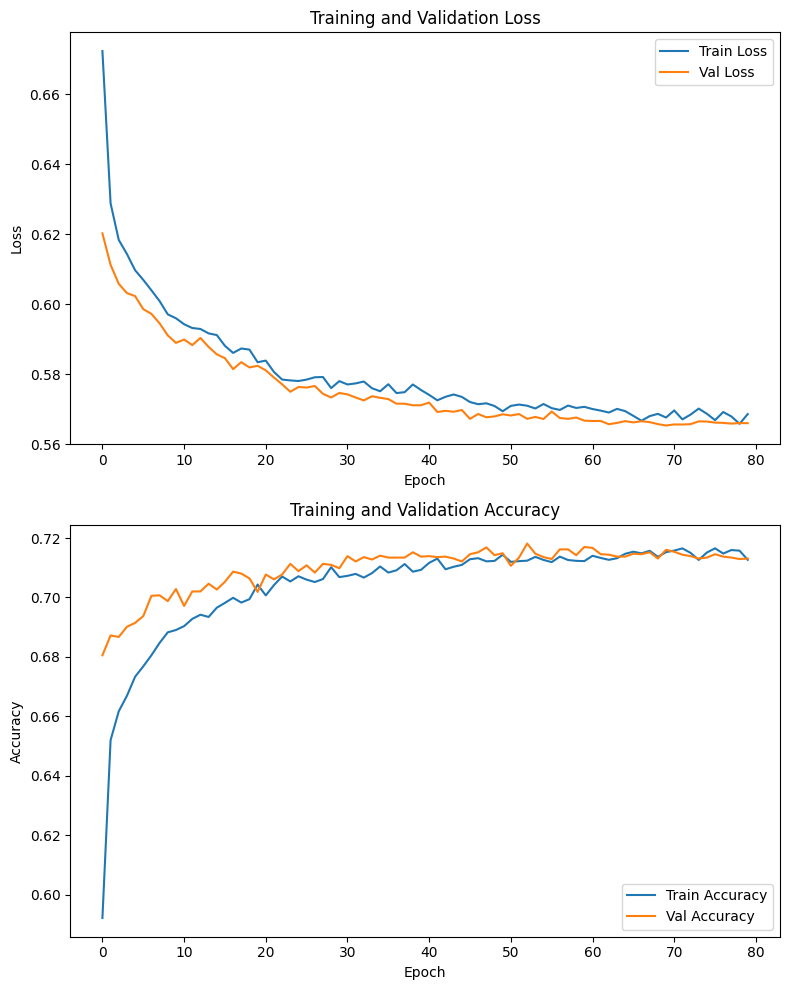

In [ ]:
# Plotting
save_loss_accuracy_plots(history, plot_path)

In [ ]:
# Testing
test_loss, test_accuracy = tf.keras.models.load_model(model_file_path).evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

193/193 [==============================] - 9s 7ms/step - loss: 0.5610 - accuracy: 0.7226
Test Loss: 0.5609751343727112
Test Accuracy: 0.7225837707519531
